In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


from scipy.integrate import ode
alpha  = -0.1
beta= 2
gamma=-2
delta=-0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha * state[0]**3 + beta*state[1]**3,
                  gamma*state[0]**3 + delta*state[1]**3])

t = np.linspace(0, 40,  80)              # time
X0 = np.array([2, 0])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y



np.random.seed(0)
yobs = X.T + np.random.normal(size=X.T.shape) * 0.02  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
#times = t
print(yobs.std(axis=0))

times = t[:40]    
times_test= t[40:]
yobs_test = yobs[40:]
yobs_norm = yobs[:40]



#yobs_norm = yobs # / yobs.std(axis=0)


## Do Bayesian Sindy
def nonlinear_oscillator_sunode_library(t, y, p):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    du_dt = p.pn[0] * y.u**3 + p.pn[1] * y.v**3 + p.pn[4] * y.u + p.pn[6] * y.v + p.pn[8] * y.u**2 + p.pn[10] * y.v**2 + p.pn[12] * y.u*y.v + p.pn[14] * y.u**2 * y.v + p.pn[16] * y.v**2 * y.u + p.pn[18]
    dv_dt = p.pn[2] * y.u**3 + p.pn[3] * y.v**3 + p.pn[5] * y.u + p.pn[7] * y.v + p.pn[9] * y.u**2 + p.pn[11] * y.v**2 + p.pn[13] * y.u*y.v + p.pn[15] * y.u**2 * y.v + p.pn[17] * y.v**2 * y.u + p.pn[19]
    return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}


model_rh = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_rh:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = pm.Deterministic('lt', pm.math.sqrt(c2)*l / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l)))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    #xi = pm.Bernoulli('xi', 0.8, shape=d
    #pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])

with model_rh:

    #trace = pm.sample(2000, tune=2000, cores=2,random_seed=1,target_accept=0.9) #,start=start)

    #trace = pm.sample(2000, tune=2000, cores=2, random_seed=1, step_kwargs={'nuts':{'target_accept':0.9}})

    trace_rh = pm.backends.load_trace('../nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/nonlinear_oscillator_normal_rh_20param_tune2000_noisep02_unscaled_gammap1_2.trace',model_rh)
        #pm.summary(trace,var_names=['pn'])






[0.5743936  0.50086108]


In [2]:
model_ss = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_ss:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    #l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    #tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    #c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    #lt = pm.Deterministic('lt', pm.math.sqrt(c2)*l / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l)))
    
    z  = pm.Laplace('z', mu=0, b=1, shape=d)
    #pn = pm.Deterministic('pn', z*tau*lt)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pn = pm.Deterministic('pn', z * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])


    #trace = pm.sample(2000, tune=2000, cores=2, random_seed=2, step_kwargs={'nuts':{'target_accept':0.9}})

    trace_ss = pm.backends.load_trace('../nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/ss/nonlinear_oscillator_normal_ss_20param_tune2000_noisep02_unscaled_gammap1_2_hightol.trace',model_ss)

    #trace = pm.sample(2000, tune=2000, cores=2, random_seed=[2,2], start=trace_ss, step_kwargs={'nuts':{'target_accept':0.9}})








In [23]:
model_gauss = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_gauss:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    pn  = pm.Normal('pn', mu=0, sigma=1, shape=d)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    #xi = pm.Bernoulli('xi', 0.8, shape=d
    #pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])

    #trace_gauss = pm.backends.load_trace('/home/hirshs/BayesianSindy-master/tabulated_runs/nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/nonlinear_oscillator_normal_gauss_20param_tune2000_noisep02_unscaled_gammap1_4.trace',model_gauss)
    trace_gauss = pm.backends.load_trace('/home/hirshs/BayesianSindy-master/tabulated_runs/nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/gauss1_rh_init/nonlinear_oscillator_normal_gauss_20param_tune2000_noisep02_unscaled_gammap1_3..trace/')


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

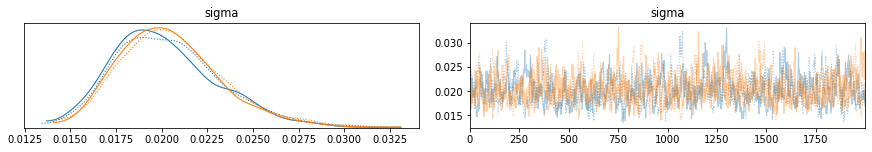

In [24]:
pm.traceplot(trace_gauss,var_names=['sigma'])

-1.975243836812115
-0.06110455019242292
-0.0004797337364599759
-0.0033081715736697492
-0.003238370904161403
0.0688854896282475
-0.02966801487220258
0.031685560935610604
0.045007300801160666
-0.013361129132140007
-0.1436157962658985
1.9333766591008317
0.0006687764305875685
-0.0881145281384163
0.054373475931388526
-0.04850026666631771
-0.03377407797669084
0.027945688206217956
0.0086465650880031
0.014764211649187356


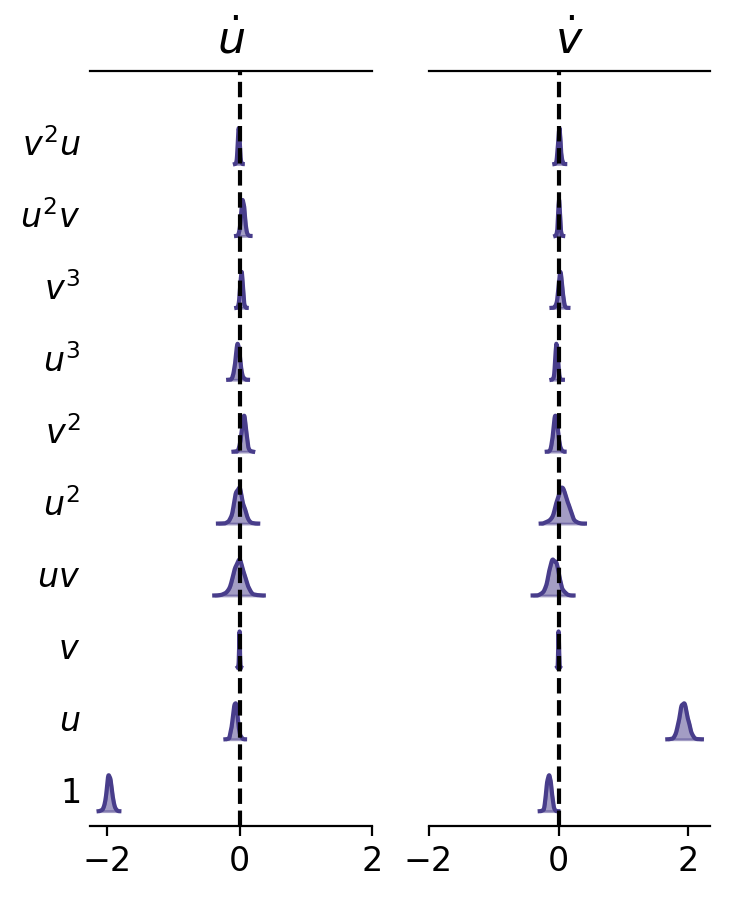

In [30]:
model_gauss = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_gauss:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    pn  = pm.Normal('pn', mu=0, sigma=1, shape=d)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    #xi = pm.Bernoulli('xi', 0.8, shape=d
    #pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])

    #trace_gauss = pm.backends.load_trace('/home/hirshs/BayesianSindy-master/tabulated_runs/nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/nonlinear_oscillator_normal_gauss_20param_tune2000_noisep02_unscaled_gammap1_5.trace',model_gauss)
    trace_gauss = pm.backends.load_trace('/home/hirshs/BayesianSindy-master/tabulated_runs/nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/gauss1_rh_init/nonlinear_oscillator_normal_gauss_20param_tune2000_noisep02_unscaled_gammap1_3..trace/')


# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (trace_gauss['pn'].T[[4,6,8,10,12,14,16,18,0,2][::-1],:], trace_gauss['pn'].T[[5,7,9,11,13,15,17,19,1,3][::-1],:])

#exps = (trace_rh['pn'].T, trace_rh['pn'].T)
colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_gauss = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_gauss.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            #if np.abs(x.mean()) > 1:
            #    x = x/10
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,10.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-2,0,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(10) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$',
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                    r'$u^3$',
                      r'$v^3$',
                      r'$u^2 v$',
                      r'$v^2 u$'], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig4b.pdf')

-1.960359441663348
-0.07553130534859764
-0.00018065727432345184
-0.0015399363480086692
-0.0007973217546539957
0.00044457426083366336
0.0005081786360536938
0.001038356706196647
-0.001030421438537918
0.0004791372970818844
-0.11845066605112503
2.0233161352866134
9.102237008135061e-05
-0.0013035728635952537
-0.000588027271115843
-4.639429710824594e-05
-1.2892950014491145e-05
-0.0009163912211487685
-0.0005638741646409873
-0.002826961493421508


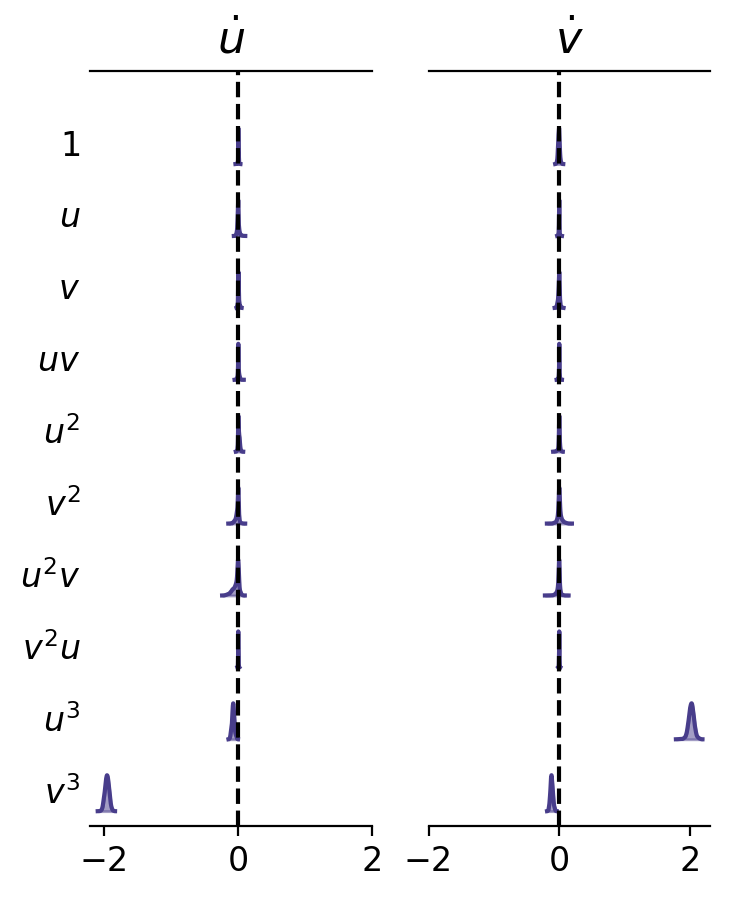

In [6]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = (trace_rh['pn'].T[[4,6,8,10,12,14,16,18,0,2][::-1],:], trace_rh['pn'].T[[5,7,9,11,13,15,17,19,1,3][::-1],:])

#exps = (trace_rh['pn'].T, trace_rh['pn'].T)
colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_rh = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_rh.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            #if np.abs(x.mean()) > 1:
            #    x = x/10
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,10.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-2,0,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(10) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$',
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                      r'$u^2 v$',
                      r'$v^2 u$',
                      r'$u^3$',
                      r'$v^3$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig4b.pdf')

In [7]:
2

2

-1.9618210107964598
0.00037101406297837536
-3.465434847535996e-05
-0.0022968966882638275
-0.000413407641952912
-0.00019754288812982163
0.00024331679525945588
0.00014324336727782397
3.16673811950538e-05
8.736695762897781e-06
-0.10834569010560864
2.035773942207585
2.5396371560698454e-05
8.176531483003457e-05
0.0008491691213623476
0.00028878718296330985
-0.00015051555640911707
9.938355958946654e-05
1.2321420185276905e-05
2.9603058593126452e-05


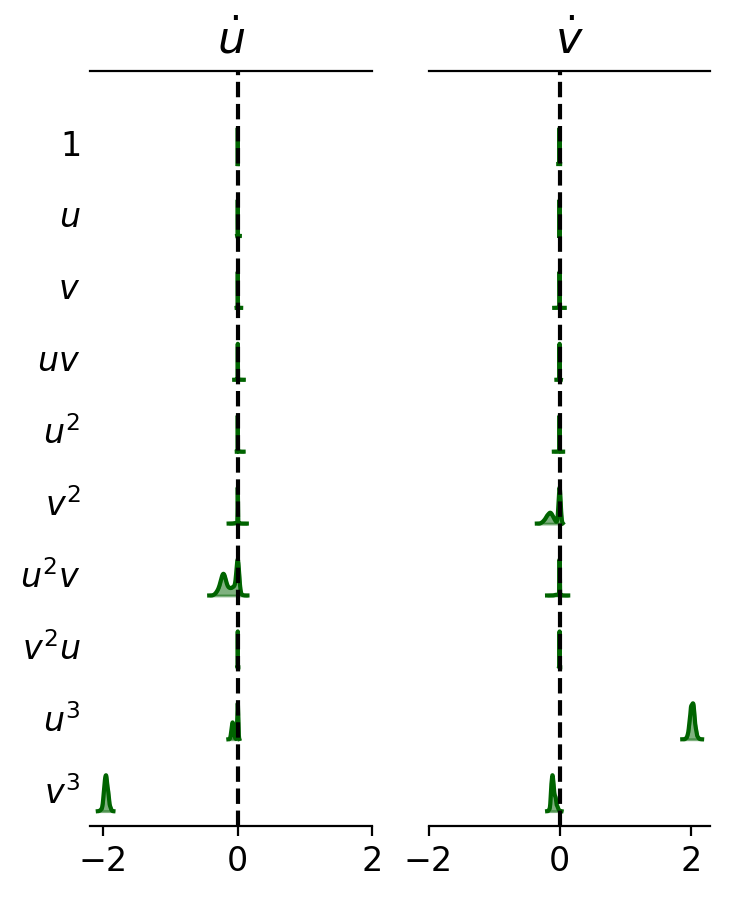

In [8]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000


exps = (trace_ss['pn'].T[[4,6,8,10,12,14,16,18,0,2][::-1],:], trace_ss['pn'].T[[5,7,9,11,13,15,17,19,1,3][::-1],:])


colors = ['darkgreen','darkgreen']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        #print(i)
        sns.kdeplot(data=v+np.random.randn(*v.shape)*0.0002,color=colors[sbplt],ax=ax[sbplt])
        #if (i==5 and sbplt==1) or (i==4 and sbplt==0) :
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,10.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-2,0,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(10) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$',
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                      r'$u^2 v$',
                      r'$v^2 u$',
                      r'$u^3$',
                      r'$v^3$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig4a.pdf')

In [9]:
# plot mean and intervals
with model_ss:
    ppc_ss = pm.sample_posterior_predictive(trace_ss, samples=8000,var_names=['uobs','vobs'], random_seed=2)

100%|██████████| 8000/8000 [00:34<00:00, 229.31it/s]


In [10]:
with model_rh:
    ppc_rh = pm.sample_posterior_predictive(trace_rh, samples=8000,var_names=['uobs','vobs'], random_seed=2)

100%|██████████| 8000/8000 [01:07<00:00, 118.79it/s]


In [12]:
from scipy.integrate import ode
alpha  = -0.1
beta= 2
gamma=-2
delta=-0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha * state[0]**3 + beta*state[1]**3,
                  gamma*state[0]**3 + delta*state[1]**3])

t = np.linspace(0, 20,  100)              # time
X0 = np.array([2, 0])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y



np.random.seed(0)
yobs = X.T + np.random.normal(size=X.T.shape) * 0.02  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
#times = t
print(yobs.std(axis=0))

# Apply sindy to data
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
#dx = sfd(inp)
data = yobs_norm / yobs_norm.std(axis=0)
dx = sfd(data)
optimizer = ps.STLSQ(threshold=0.1)
feature_library = ps.PolynomialLibrary(degree=3)
model = ps.SINDy(feature_names=["x", "y"],optimizer=optimizer,feature_library=feature_library)
model.fit(data, t=times)
from scipy.integrate import solve_ivp, odeint
def my_int(fun, y0 ,t_span):
    print('y0',y0)
    print('fun',(np.min(t_span),np.max(t_span)))
    sol = solve_ivp(fun,(np.min(t_span),np.max(t_span)),y0) #,t_eval=t_span)
    print(sol)
    return sol.y

#def my_int(fun, y0 ,t_span):
#    print(odeint(fun,y0,t_span).shape)
#    return odeint(fun,y0,t_span)
sim_time = np.linspace(0,40,100)

#solve_ivp(fun, t_span, y0) # method='BDF')
#sim_time = np.linspace(0,40,200)
sim = model.simulate(data[0],sim_time,integrator=my_int)
model.print()

[0.68952327 0.66234373]
y0 [2.74221491 0.01278504]
fun (0.0, 40.0)


TypeError: 'float' object is not subscriptable

In [13]:
def nonlinear_oscillator_sunode_library_mat(t, y, pn):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    u,v = y
    state = np.array([u**3, v**3,u,v,u**2,v**2,u*v,u**2 * v, v**2 * u,1]) 
    #return state @ np.reshape(pn,(10,2),'C')
    return np.array([pn[0] * u**3 + pn[1] * v**3 + pn[4] * u + pn[6] * v + pn[8] * u**2 + pn[10] * v**2 + pn[12] * u*v + pn[14] * u**2 * v + pn[16] * v**2 * u + pn[18],
     pn[2] * u**3 + pn[3] * v**3 + pn[5] * u + pn[7] * v + pn[9] * u**2 + pn[11] * v**2 + pn[13] * u*v + pn[15] * u**2 * v + pn[17] * v**2 * u + pn[19]])
    #return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}
    
    
def my_f(t,y):  
    c = model.coefficients()
    params = c[:,[9,2,3,4,6,5,0,7,8,1]].flatten()
    nonlinear_oscillator_sunode_library_mat(t,y,params)

solve_ivp(my_f,(0,40),yobs_norm[0,:],method='BDF',t_eval=sim_time)

    
    
    

IndexError: too many indices for array

In [ ]:
model.coefficients()

In [ ]:
yobs_norm[0,:]

In [ ]:
model.equations()

In [ ]:
from scipy.integrate import solve_ivp
def exponential_decay(t, y): return -0.5 * y
sol = solve_ivp(exponential_decay, [0, 10], [2, 4, 8])
print(sol.t)


print(sol.y)

In [ ]:
odeint(exponential_decay, [2, 4, 8], [0,10])

In [ ]:
model.predict()

In [ ]:
plt.figure()
plt.plot(sim)
plt.show()

In [ ]:
sim_time.shape

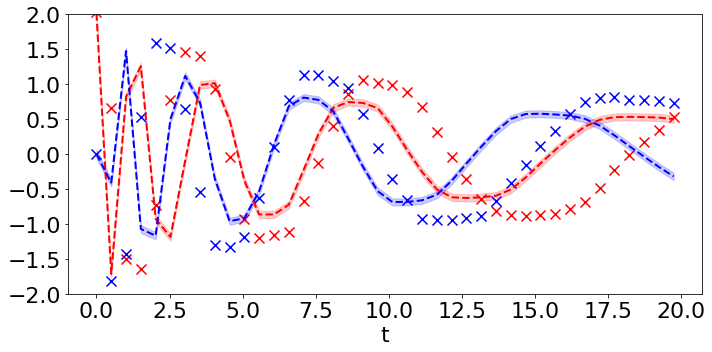

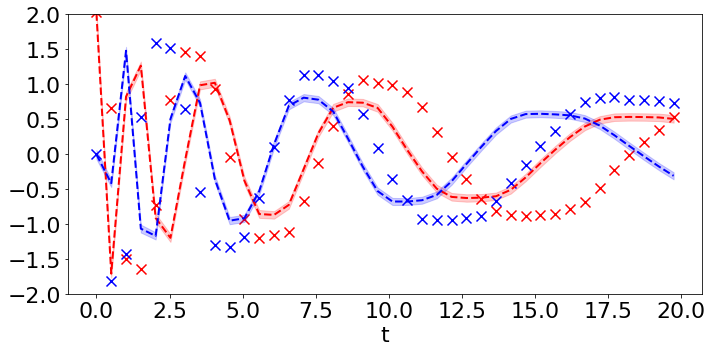

In [15]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T 
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 1,99
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    #plt.plot(sim_time,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    #plt.plot(sim_time,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:40,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xlabel('t',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig4d.pdf')

plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T 
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 1,99
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    #plt.plot(sim_time,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    #plt.plot(sim_time,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:40,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xlabel('t',fontsize=22)
    #plt.ylabel('Population',fontsize=22)
    plt.tight_layout()
    plt.savefig('fig4c.pdf')


    

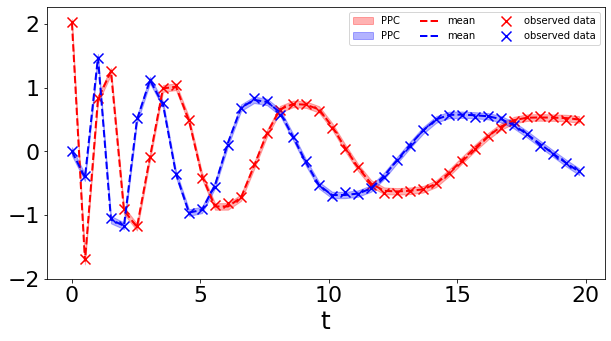

In [16]:
plt.figure(figsize=(10,5))
ax = plt.gca()
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T
    above = np.percentile(series,99,axis=1)
    below = np.percentile(series,1,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(times, below, above, color=colors[i], alpha=0.3,label='PPC')
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.xticks([0,5,10,15,20],fontsize=22)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels,ncol=3)
#plt.legend(ncol=3)
plt.xlabel('t',fontsize=25)
plt.savefig('legend.pdf')

In [17]:
def nonlinear_oscillator_sunode_library_mat(t, y, pn):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    u,v = y
    state = np.array([u**3, v**3,u,v,u**2,v**2,u*v,u**2 * v, v**2 * u,1]) 
    #return state @ np.reshape(pn,(10,2),'C')
    return np.array([pn[0] * u**3 + pn[1] * v**3 + pn[4] * u + pn[6] * v + pn[8] * u**2 + pn[10] * v**2 + pn[12] * u*v + pn[14] * u**2 * v + pn[16] * v**2 * u + pn[18],
     pn[2] * u**3 + pn[3] * v**3 + pn[5] * u + pn[7] * v + pn[9] * u**2 + pn[11] * v**2 + pn[13] * u*v + pn[15] * u**2 * v + pn[17] * v**2 * u + pn[19]])
    #return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}
    
    

In [18]:
# plot mean and intervals
with model_ss:
    ppc_forecast_ss = pm.sample_posterior_predictive(trace_ss, samples=8000,var_names=['y0','pn','sigma'], random_seed=2)


t = np.linspace(0, 40,  80)              # time
credibility_interval_ss = np.zeros((500,2,len(t)))
for k in range(500):
    y0 = ppc_forecast_ss['y0'][k]                  # initials conditions: 10 rabbits and 5 foxes
    pn = ppc_forecast_ss['pn'][k]
    sigma = ppc_forecast_ss['sigma'][k]
    r = ode(nonlinear_oscillator_sunode_library_mat).set_integrator('dopri5')
    r.set_initial_value(y0, t[0])
    r.set_f_params(pn)
    credibility_interval_ss[k,:,0] = y0
    for i, _t in enumerate(t):
        if i == 0:
            continue
        r.integrate(_t)
        credibility_interval_ss[k,:, i] = r.y + np.random.randn(*r.y.shape) * sigma
    if k % 100 == 0:
        print(k)


'''
y0 = ppc_forecast['y0'][0]   
pn = ppc_forecast['pn'][0]      
    
y_hat, _, _, _ = s.solve_ivp(y0={
        'u': (y0[0], ()),
        'v': (y0[1], ()),
        },
        params={
            'pn' : (pn,d),
            'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
        },
        rhs=nonlinear_oscillator_sunode_library,
        make_solver='RK45',
        tvals=times,
        t0=times[0],
    )
    '''

100%|██████████| 8000/8000 [00:02<00:00, 2699.21it/s]


0
100
200
300
400


"\ny0 = ppc_forecast['y0'][0]   \npn = ppc_forecast['pn'][0]      \n    \ny_hat, _, _, _ = s.solve_ivp(y0={\n        'u': (y0[0], ()),\n        'v': (y0[1], ()),\n        },\n        params={\n            'pn' : (pn,d),\n            'tmp': np.zeros(1),  # Theano wants at least one fixed parameter\n        },\n        rhs=nonlinear_oscillator_sunode_library,\n        make_solver='RK45',\n        tvals=times,\n        t0=times[0],\n    )\n    "

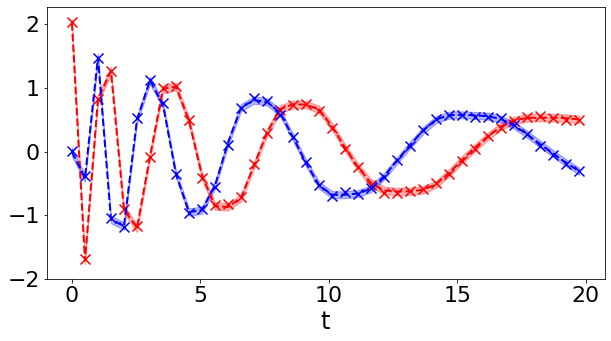

In [19]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T
    above = np.percentile(series,99.5,axis=1)
    below = np.percentile(series,0.5,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([0,5,10,15,20],fontsize=22)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
    plt.xlabel('t',fontsize=24)

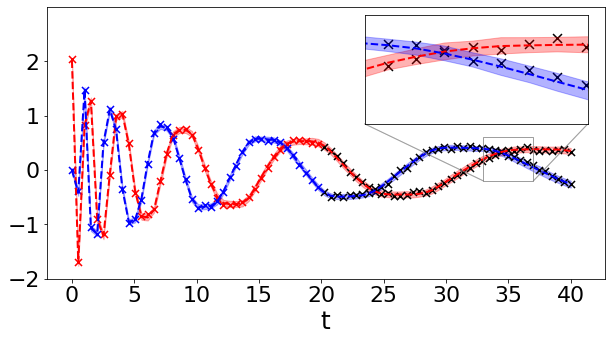

In [20]:
fig, ax= plt.subplots(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
axins = ax.inset_axes([0.57, 0.57, 0.4, 0.4])
for i in range(2):
    series = credibility_interval_ss[:,i,:].T
    above = np.percentile(series,99,axis=1)
    below = np.percentile(series,1,axis=1)
    #mu = series.mean(axis=1)
    #plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(t, below, above, color=colors[i], alpha=0.3)
    #plt.plot(np.hstack((times,times_test)),sim[:,i])
    mu = series.mean(axis=1)
    plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=50, alpha=1.0, label="observed data");
    plt.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=50,alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xticks([0,5,10,15,20,25,30,35,40],fontsize=22)
    axins.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=80,alpha=1.0, label="observed data");
    axins.fill_between(t, below, above, color=colors[i], alpha=0.3)
    axins.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    axins.set_xlim([33,37])
    axins.set_ylim([-0.2,0.6])
    plt.yticks([-2,-1,0,1,2,3],fontsize=22)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    axins.set_yticks([])
    axins.set_xticks([])
    ax.indicate_inset_zoom(axins)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
    plt.xlabel('t',fontsize=25)

In [21]:
# plot mean and intervals
with model_rh:
    ppc_forecast_rh = pm.sample_posterior_predictive(trace_rh, samples=8000,var_names=['y0','pn','sigma'], random_seed=2)

t = np.linspace(0, 40,  80)              # time
credibility_interval_rh = np.zeros((500,2,len(t)))
for k in range(500):
    y0 = ppc_forecast_rh['y0'][k]                  # initials conditions: 10 rabbits and 5 foxes
    pn = ppc_forecast_rh['pn'][k]
    sigma = ppc_forecast_ss['sigma'][k]
    r = ode(nonlinear_oscillator_sunode_library_mat).set_integrator('dopri5')
    r.set_initial_value(y0, t[0])
    r.set_f_params(pn)
    credibility_interval_rh[k,:,0] = y0
    for i, _t in enumerate(t):
        if i == 0:
            continue
        r.integrate(_t)
        credibility_interval_rh[k,:, i] = r.y + np.random.randn(*r.y.shape) * sigma
    if k % 100 == 0:
        print(k)


100%|██████████| 8000/8000 [00:05<00:00, 1595.05it/s]


0
100
200
300
400


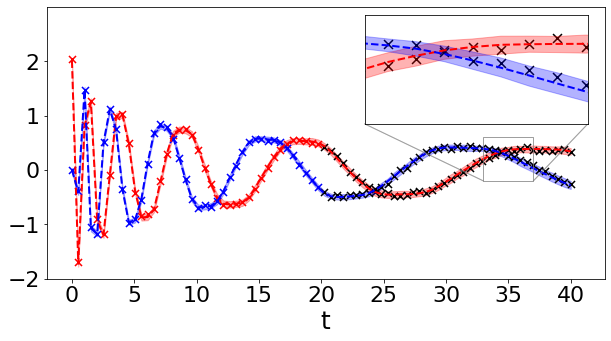

In [22]:
fig, ax= plt.subplots(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
axins = ax.inset_axes([0.57, 0.57, 0.4, 0.4])
for i in range(2):
    series = credibility_interval_rh[:,i,:].T
    above = np.percentile(series,99,axis=1)
    below = np.percentile(series,1,axis=1)
    #mu = series.mean(axis=1)
    #plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(t, below, above, color=colors[i], alpha=0.3)
    #plt.plot(np.hstack((times,times_test)),sim[:,i])
    mu = series.mean(axis=1)
    plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=50, alpha=1.0, label="observed data");
    plt.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=50,alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xticks([0,5,10,15,20,25,30,35,40],fontsize=22)
    axins.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=80,alpha=1.0, label="observed data");
    axins.fill_between(t, below, above, color=colors[i], alpha=0.3)
    axins.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    axins.set_xlim([33,37])
    axins.set_ylim([-0.2,0.6])
    plt.yticks([-2,-1,0,1,2,3],fontsize=22)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    axins.set_yticks([])
    axins.set_xticks([])
    ax.indicate_inset_zoom(axins)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
    plt.xlabel('t',fontsize=25)

In [ ]:
trace_gauss['pn'].mean(axis=0)

In [ ]:
trace_rh['pn'].mean(axis=0) / trace_gauss['pn'].mean(axis=0)

In [ ]:
ag = [-0.07553130534859764,
2.0233161352866134,
-1.960359441663348,
-0.11845066605112503,
0.0004791372970818844,
-0.002826961493421508,
-0.001030421438537918,
-0.0005638741646409873,
0.001038356706196647,
-0.0009163912211487685,
0.0005081786360536938,
-1.2892950014491145e-05,
0.00044457426083366336,
-4.639429710824594e-05,
-0.0007973217546539957,
-0.000588027271115843,
-0.0015399363480086692,
-0.0013035728635952537,
-0.00018065727432345184,
9.102237008135061e-05]

In [ ]:
np.array(ag) / trace_gauss['pn'].mean(axis=0)

In [ ]:
pm.summary(trace_gauss,var_names=['pn'])

In [ ]:
trace_gauss['pn'].mean(axis=0)

In [ ]:
gauss_map = np.array([-0.02500647,  1.82623344, -1.90474116, -0.05426078,  0.00386695,
        0.0302113 ,  0.0559179 , -0.0073058 ,  0.00390982,  0.01825219,
        0.06998815, -0.00991457,  0.04268199,  0.03744218,  0.16871214,
       -0.09264365, -0.25822814, -0.26111994, -0.01035466, -0.00204225])

In [ ]:
np.array(ag) / gauss_map 

In [ ]:
from scipy.integrate import ode
from scipy import optimize
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


alpha  = -0.1
beta= 2
gamma=-2
delta=-0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha * state[0]**3 + beta*state[1]**3,
                  gamma*state[0]**3 + delta*state[1]**3])

t = np.linspace(0, 20, 40)              # time
X0 = np.array([2, 0])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T + np.random.normal(size=X.T.shape) * 0.02  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t
print(yobs.std(axis=0))
yobs_norm = yobs # / yobs.std(axis=0)


## Do Bayesian Sindy
def nonlinear_oscillator_sunode_library(t, y, p):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    du_dt = p.pn[0] * y.u**3 + p.pn[1] * y.v**3 + p.pn[4] * y.u + p.pn[6] * y.v + p.pn[8] * y.u**2 + p.pn[10] * y.v**2 + p.pn[12] * y.u*y.v + p.pn[14] * y.u**2 * y.v + p.pn[16] * y.v**2 * y.u + p.pn[18]
    dv_dt = p.pn[2] * y.u**3 + p.pn[3] * y.v**3 + p.pn[5] * y.u + p.pn[7] * y.v + p.pn[9] * y.u**2 + p.pn[11] * y.v**2 + p.pn[13] * y.u*y.v + p.pn[15] * y.u**2 * y.v + p.pn[17] * y.v**2 * y.u + p.pn[19]
    return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}
model_gauss_2 = pm.Model()

d = 20

slab_df = 4
slab_scale = 2



with model_gauss_2:

    #sigma = pm.Gamma('sigma',1,0.1,shape=2)  #  pm.Gamma('sigma',1,1,shape=2) #
    #sigma = pm.Uniform('sigma',0,1,shape=2)#pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    sigma = [0.02,0.02]
    #pn = pm.Normal('sigma',mu=)
    
    #pn  = pm.Uniform('pn',-3,3,shape=d)
    pn = pm.Normal('pn',mu=0, sigma=1, shape=d) 
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.1, shape=2)
    #xi = pm.Bernoulli('xi', 0.8, shape=d
    #pnss = pm.Deterministic('pnss', pn * xi)
    #y0 = pm.Uniform('y0',-2.5,2.5,shape=2)#
    y00 = pm.Laplace('y00', mu=0, b=1)
    y01 = pm.Laplace('y01', mu=0, b=1)
    #y00 = pm.Uniform('y00',yobs_norm[0,0]-0.1,yobs_norm[0,0]+0.1)
    #y01 = pm.Uniform('y01',yobs_norm[0,1]-0.1,yobs_norm[0,1]+0.1)
    #y0 = pm.HalfFlat('y0',shape=2)
    
    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y00, ()),
            'v': (y01, ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='BDF',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])

    #trace_gauss = pm.backends.load_trace('/home/hirshs/BayesianSindy-master/tabulated_runs/nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/nonlinear_oscillator_normal_gauss_20param_tune2000_noisep02_unscaled_gammap1_5.trace',model_gauss)
    start = pm.find_MAP(maxeval=100,method='Nelder-Mead')
    start['pn'] = trace_rh['pn'].mean(axis=0)
    start['y00'] = trace_rh['y0'].mean(axis=0)[0]
    start['y01'] = trace_rh['y0'].mean(axis=0)[1]
    #start['sigma'] = trace_rh['sigma'].mean(axis=0) 
    start = pm.find_MAP(start=start,maxeval=10000,method='L-BFGS-B')

print(start)



#t = np.linspace(0, 24,  50)              # time
X = np.zeros((2,len(t)))

def nonlinear_oscillator_sunode_library_mat(t, y, pn):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    u,v = y
    state = np.array([u**3, v**3,u,v,u**2,v**2,u*v,u**2 * v, v**2 * u,1]) 
    #return state @ np.reshape(pn,(10,2),'C')
    return np.array([pn[0] * u**3 + pn[1] * v**3 + pn[4] * u + pn[6] * v + pn[8] * u**2 + pn[10] * v**2 + pn[12] * u*v + pn[14] * u**2 * v + pn[16] * v**2 * u + pn[18],
     pn[2] * u**3 + pn[3] * v**3 + pn[5] * u + pn[7] * v + pn[9] * u**2 + pn[11] * v**2 + pn[13] * u*v + pn[15] * u**2 * v + pn[17] * v**2 * u + pn[19]])

y0 = [start['y00'],start['y01']]                # initials conditions: 10 rabbits and 5 foxes
pn = start['pn']
r = ode(nonlinear_oscillator_sunode_library_mat).set_integrator('dopri5')
r.set_initial_value(y0, t[0])
r.set_f_params(pn)
X[:,0] = y0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

plt.figure()
plt.plot(t,X.T)
plt.plot(t,yobs_norm,'x')
plt.show()

In [ ]:
start['pn'] = trace_rh['pn'].mean(axis=0)
start['y00'] = trace_rh['y0'].mean(axis=0)[0]
start['y01'] = trace_rh['y0'].mean(axis=0)[1]

In [ ]:
np.array(ag)  / start['pn']

In [33]:
# Shrinkage coefficients regularized horseshoe
np.reshape(np.array(res_rh) / np.array(res_gauss),(10,2),order='F')[::-1,:]

array([[-3.58605394e-02, -1.91473921e-01],
       [-2.28945398e-02, -6.52136610e-02],
       [ 3.27706588e-02, -3.27918645e-02],
       [-1.71288385e-02,  3.81740992e-04],
       [ 6.45381579e-03,  9.56578186e-04],
       [ 2.46210758e-01, -1.08145978e-02],
       [ 4.65494704e-01,  1.47940742e-02],
       [ 3.76578215e-01,  1.36102838e-01],
       [ 1.23609952e+00,  1.04651938e+00],
       [ 9.92464528e-01,  8.24774636e-01]])

In [ ]:
trace_gauss['sigma'].mean(axis=0)

In [ ]:
trace_gauss['pn'].mean(axis=0)

In [ ]:
trace_rh['pn'].mean(axis=0) / trace_gauss['pn'].mean(axis=0) 

In [ ]:
trace_rh['pn'].mean(axis=0)a

In [31]:
res_rh

[-1.960359441663348,
 -0.07553130534859764,
 -0.00018065727432345184,
 -0.0015399363480086692,
 -0.0007973217546539957,
 0.00044457426083366336,
 0.0005081786360536938,
 0.001038356706196647,
 -0.001030421438537918,
 0.0004791372970818844,
 -0.11845066605112503,
 2.0233161352866134,
 9.102237008135061e-05,
 -0.0013035728635952537,
 -0.000588027271115843,
 -4.639429710824594e-05,
 -1.2892950014491145e-05,
 -0.0009163912211487685,
 -0.0005638741646409873,
 -0.002826961493421508]

In [32]:
res_gauss

[-1.975243836812115,
 -0.06110455019242292,
 -0.0004797337364599759,
 -0.0033081715736697492,
 -0.003238370904161403,
 0.0688854896282475,
 -0.02966801487220258,
 0.031685560935610604,
 0.045007300801160666,
 -0.013361129132140007,
 -0.1436157962658985,
 1.9333766591008317,
 0.0006687764305875685,
 -0.0881145281384163,
 0.054373475931388526,
 -0.04850026666631771,
 -0.03377407797669084,
 0.027945688206217956,
 0.0086465650880031,
 0.014764211649187356]

In [ ]:
trace_ss['xi'].mean(axis=0)[[4,6,8,10,12,14,16,18,0,2,5,7,9,11,13,15,17,19,1,3]].reshape(10,2,order='F')

In [ ]:
(res_rh / pn[[4,6,8,10,12,14,16,18,0,2,5,7,9,11,13,15,17,19,1,3]]).reshape(10,2,order='F')

In [ ]:
trace_ss['pn'].mean(axis=0)[[4,6,8,10,12,14,16,18,0,2,5,7,9,11,13,15,17,19,1,3]].reshape(10,2,order='F')

In [ ]:
trace_rh['pn'].mean(axis=0)[[4,6,8,10,12,14,16,18,0,2,5,7,9,11,13,15,17,19,1,3]].reshape(10,2,order='F')

In [ ]:
from scipy.integrate import ode
alpha  = -0.1
beta= 2
gamma=-2
delta=-0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha * state[0]**3 + beta*state[1]**3,
                  gamma*state[0]**3 + delta*state[1]**3])

t = np.linspace(0, 20, 300)              # time
X0 = np.array([2, 0])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y



np.random.seed(0)
yobs = X.T + np.random.normal(size=X.T.shape) * 0.02  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
#times = t
#print(yobs.std(axis=0))
        
# Initialize parameters with least squares and all other values with MAP
yobs_norm = yobs
inp = yobs_norm
u = inp[:,0]
v = inp[:,1]

θ = np.array([u**3,v**3,u,v,u**2,v**2,u*v,u**2 * v, v**2 * u, np.ones(u.shape)]).T

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
dx = sfd(inp) / (t[1] - t[0])
guess = np.linalg.lstsq(θ,dx)[0].T 

In [ ]:
dx.shape

In [ ]:
guess

In [ ]:
np.abs((sfd(inp))).mean()